In [49]:
import sys
sys.path.append('/home/franzihe/Documents/Python/Thesis/')
#sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/weather_mast/')

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import seaborn as sns
import createFolder as cF
import matplotlib.ticker as ticker
import matplotlib as mpl
import pandas as pd


np.warnings.filterwarnings('ignore')

In [50]:
# plot cosmetics
sns.set_context('paper')

sns.set(font = 'Serif', font_scale = 1.2, )
sns.set_style('ticks', 
                  {'font.family':'serif', #'font.serif':'Helvetica'
                   'grid.linestyle': '--',
                   'axes.grid': True,
                  }, 
                   )
# Set the palette to the "pastel" default palette:
sns.set_palette("colorblind")

In [51]:
m = ['12', '01', '02']
station = 'Haukeliseter'
meps_run = ['CTRL', 'ICE-T']

In [52]:
savefig = 0
if savefig == 1:
    figdir = '/home/franzihe/Documents/Figures/Weathermast_MEPS_Retrieval/%s/CTRL_ICET/' %(station)
    cF.createFolder('%s/' %figdir)
    form = 'png'

In [53]:
Rd = 287.    # gas constant for dry air [J kg^-1 K^-1]

In [54]:
Ret_dir = dict()
MEPS_dir = dict()

In [55]:
## MRR + SWC ######
fn_ret     = dict()
time_ret   = dict()
height_MRR = dict()
Ze         = dict()

height_SWC = dict()
SWC        = dict()
SWP        = dict()

obs_west_idx = dict()
obs_east_idx = dict()
obs_wind_direction = dict()
obs_wind_speed = dict()

widx = dict()
eidx = dict()
SWP_west_0_4 = dict()
SWP_east_0_4 = dict()
SWP_west_4_8 = dict()
SWP_east_4_8 = dict()
SWP_west_8_12 = dict()
SWP_east_8_12 = dict()
SWP_west_12_16 = dict()
SWP_east_12_16 = dict()
SWP_west_16_20 = dict()
SWP_east_16_20 = dict()
SWP_west_20 = dict()
SWP_east_20 = dict()

SWC_west_0_4 = dict()
SWC_east_0_4 = dict()
SWC_west_4_8 = dict()
SWC_east_4_8 = dict()
SWC_west_8_12 = dict()
SWC_east_8_12 = dict()
SWC_west_12_16 = dict()
SWC_east_12_16 = dict()
SWC_west_16_20 = dict()
SWC_east_16_20 = dict()
SWC_west_20 = dict()
SWC_east_20 = dict()


meps_wind_speed = dict()
meps_wind_direction = dict()
meps_west_idx     = dict()
meps_east_idx     = dict()


In [56]:
## MEPS #####
fn_meps = dict()
c_water = dict()
c_ice = dict()
c_snow = dict()
c_rain             = dict()
c_grauple          = dict()
layer_thickness    = dict()
pressure_ml        = dict()
air_temperature_ml = dict()
density_ml         = dict()

ice_amount_ml = dict()
height_MEPS = dict()
time_MEPS = dict()
SWC_MEPS = dict()
SWP_MEPS = dict()

In [57]:
SWP_MEPS_west_0_4 = dict()
SWP_MEPS_east_0_4 = dict()
SWP_MEPS_west_4_8 = dict()
SWP_MEPS_east_4_8 = dict()
SWP_MEPS_west_8_12 = dict()
SWP_MEPS_east_8_12 = dict()
SWP_MEPS_west_12_16 = dict()
SWP_MEPS_east_12_16 = dict()
SWP_MEPS_west_16_20 = dict()
SWP_MEPS_east_16_20 = dict()
SWP_MEPS_west_20 = dict()
SWP_MEPS_east_20 = dict()

SWC_MEPS_west_0_4 = dict()
SWC_MEPS_east_0_4 = dict()
SWC_MEPS_west_4_8 = dict()
SWC_MEPS_east_4_8 = dict()
SWC_MEPS_west_8_12 = dict()
SWC_MEPS_east_8_12 = dict()
SWC_MEPS_west_12_16 = dict()
SWC_MEPS_east_12_16 = dict()
SWC_MEPS_west_16_20 = dict()
SWC_MEPS_east_16_20 = dict()
SWC_MEPS_west_20 = dict()
SWC_MEPS_east_20 = dict()


vals_MEPS_west_0_4 = dict()
vals_MEPS_east_0_4 = dict()
vals_MEPS_west_4_8 = dict()
vals_MEPS_east_4_8 = dict()
vals_MEPS_west_8_12 = dict()
vals_MEPS_east_8_12 = dict()
vals_MEPS_west_12_16 = dict()
vals_MEPS_east_12_16 = dict()
vals_MEPS_west_16_20 = dict()
vals_MEPS_east_16_20 = dict()
vals_MEPS_west_20 = dict()
vals_MEPS_east_20 = dict()

SWC_MEPS_w_0_4 = dict()
SWC_MEPS_e_0_4 = dict()
SWC_MEPS_w_4_8 = dict()
SWC_MEPS_e_4_8 = dict()
SWC_MEPS_w_8_12 = dict()
SWC_MEPS_e_8_12 = dict()
SWC_MEPS_w_12_16 = dict()
SWC_MEPS_e_12_16 = dict()
SWC_MEPS_w_16_20 = dict()
SWC_MEPS_e_16_20 = dict()
SWC_MEPS_w_20 = dict()
SWC_MEPS_e_20 = dict()

In [58]:
def find_SWP_WD_WS(_widx, _eidx, 
                   wind_speed,
                   SWP, SWC, lower_WS, upper_WS):
    
    IDX2 = np.arange(np.array(_widx).shape[0])
    IDX3 = np.arange(np.array(_eidx).shape[0])

    ######################
    ## 0 - 4 m/s
    
    
    
    if len(_widx) == 0.:
        west_WS = np.empty(shape = (1,))
        west_WS[:] = np.nan
        SWP_west = np.nan
        SWC_west = np.empty(shape = SWC.shape)
        SWC_west[:] = np.nan
    else:
        west_WS = IDX2[np.logical_and(wind_speed[_widx,] >= lower_WS,
                                      wind_speed[_widx,] < upper_WS)]
#        SWP_west = np.nansum(SWP[_widx][west_WS])
        SWP_west = np.nanmean(SWP[_widx][west_WS])
        if len(west_WS) == 0:
            SWC_west = np.empty(shape = SWC.shape)
            SWC_west[:] = np.nan
        else:
            SWC_west = np.empty(shape = SWC[_widx][west_WS].shape)
            SWC_west[:] = SWC[_widx][west_WS]

    if len(_eidx) == 0:
        east_WS = np.empty(shape = (1,))
        east_WS[:] = np.nan
        SWP_east = np.nan
        SWC_east = np.empty(shape = SWC.shape)
        SWC_east[:] = np.nan
    else:
        east_WS = IDX3[np.logical_and(wind_speed[_eidx,] >= lower_WS,
                                      wind_speed[_eidx] < upper_WS)]
#        SWP_east = np.nansum(SWP[_eidx][east_WS])
        SWP_east = np.nanmean(SWP[_eidx][east_WS])
        if len(east_WS) == 0:
            SWC_east = np.empty(shape = SWC.shape)
            SWC_east[:] = np.nan
        SWC_east = np.empty(shape = SWC[_eidx][east_WS].shape)
        SWC_east[:] = SWC[_eidx][east_WS]
    
    return(SWP_west, SWP_east, SWC_west, SWC_east)

In [59]:
def find_SWP_WD_WS_MEPS(_widx, _eidx, 
                   wind_speed,
                   SWP, SWC, lower_WS, upper_WS):
    
    IDX2 = np.array(np.where(~np.isnan(_widx)))
    IDX3 = np.array(np.where(~np.isnan(_eidx)))

    ######################
    

    if len(_widx) == 0.:
        west_WS = np.empty(shape = (1,))
        west_WS[:] = np.nan
        SWP_west = np.nan
        SWC_west = np.empty(shape = SWC.shape)
        SWC_west[:] = np.nan
    else:
        west_WS = IDX2[0, np.logical_and(wind_speed[np.where(~np.isnan(_widx,))] >= lower_WS,
                                         wind_speed[np.where(~np.isnan(_widx,))] < upper_WS)]
#        SWP_west = np.nansum(SWP[west_WS])
        SWP_west = np.nanmean(SWP[west_WS])
        if len(west_WS) == 0:
            SWC_west = np.empty(shape = SWC.shape)
            SWC_west[:] = np.nan
        else:
            SWC_west = np.empty(shape = SWC[west_WS].shape)
            SWC_west[:] = SWC[west_WS]


    if len(_eidx) == 0:
        east_WS = np.empty(shape = (1,))
        east_WS[:] = np.nan
        SWP_east = np.nan
        SWC_east = np.empty(shape = SWC.shape)
        SWC_east[:] = np.nan
    else:
        east_WS = IDX3[0, np.logical_and(wind_speed[np.where(~np.isnan(_eidx,))] >= lower_WS,
                                         wind_speed[np.where(~np.isnan(_eidx,))] < upper_WS)]
#        SWP_east = np.nansum(SWP[east_WS])
        SWP_east = np.nansum(SWP[east_WS])
        if len(west_WS) == 0:
            SWC_east = np.empty(shape = SWC.shape)
            SWC_east[:] = np.nan
        else:
            SWC_east = np.empty(shape = SWC[east_WS].shape)
            SWC_east[:] = SWC[east_WS]
    
    return(SWP_west, SWP_east, SWC_west, SWC_east)

In [60]:
def get_array_of_dictionary(variable):
    
    vals_west = []
    for v in variable.items():
        vals_west.append(v)
    vals_west = np.array(vals_west)
    return(vals_west)

In [61]:
def get_pd_of_dictionary(variable, date):
    df0 = pd.DataFrame()
    for Date in date:
        df1 = pd.DataFrame(variable[int(Date)][:])
        df0 = pd.concat([df0, df1])

    df0 = df0.reset_index(drop = True)
    return(df0)

In [62]:
for meps in meps_run:

    ################################################################
    ### MRR ### Retrieval ### Eklima
    Ret_dir[meps] = '/home/franzihe/Documents/Data/Weathermast_MEPS_Retrieval/%s/%s' %(station, meps)

    ################################################################
    ### MEPS
    #'../../../Data/MEPS/%s/%s/%s%s%s_00.nc' %(station,meps, year, month, day,)
    MEPS_dir[meps] = '/home/franzihe/Documents/Data/MEPS/%s/%s' %(station, meps)

    
    

    fn_ret[meps] = dict()
    time_ret[meps]   = dict()
    height_MRR[meps] = dict()
    Ze[meps]         = dict()

    height_SWC[meps] = dict()
    SWC[meps]        = dict()
    SWP[meps]        = dict()
    
    obs_west_idx[meps] = dict()
    obs_east_idx[meps] = dict()
    obs_wind_direction[meps] = dict()
    obs_wind_speed[meps] = dict()

    widx[meps] = dict()
    eidx[meps] = dict()

    SWP_west_0_4[meps] = dict()
    SWP_east_0_4[meps] = dict()
    SWP_west_4_8[meps] = dict()
    SWP_east_4_8[meps] = dict()
    SWP_west_8_12[meps] = dict()
    SWP_east_8_12[meps] = dict()
    SWP_west_12_16[meps] = dict()
    SWP_east_12_16[meps] = dict()
    SWP_west_16_20[meps] = dict()
    SWP_east_16_20[meps] = dict()
    SWP_west_20[meps] = dict()
    SWP_east_20[meps] = dict()
    
    SWC_west_0_4[meps] = dict()
    SWC_east_0_4[meps] = dict()
    SWC_west_4_8[meps] = dict()
    SWC_east_4_8[meps] = dict()
    SWC_west_8_12[meps] = dict()
    SWC_east_8_12[meps] = dict()
    SWC_west_12_16[meps] = dict()
    SWC_east_12_16[meps] = dict()
    SWC_west_16_20[meps] = dict()
    SWC_east_16_20[meps] = dict()
    SWC_west_20[meps] = dict()
    SWC_east_20[meps] = dict()



    meps_wind_speed[meps] = dict()
    meps_wind_direction[meps] = dict()
    meps_west_idx[meps]     = dict()
    meps_east_idx[meps]    = dict()
    
    
    fn_meps[meps] = dict()
    c_water[meps] = dict()
    c_ice[meps] = dict()
    c_snow[meps] = dict()
    c_rain[meps] = dict()
    c_grauple[meps] = dict()
    layer_thickness[meps] = dict()
    pressure_ml[meps] = dict()
    air_temperature_ml[meps] = dict()
    density_ml[meps] = dict()

    ice_amount_ml[meps] = dict()
    height_MEPS[meps] = dict()
    time_MEPS[meps] = dict()
    SWC_MEPS[meps] = dict()
    SWP_MEPS[meps] = dict()
    
    SWP_MEPS_west_0_4[meps] = dict()
    SWP_MEPS_east_0_4[meps] = dict()
    SWP_MEPS_west_4_8[meps] = dict()
    SWP_MEPS_east_4_8[meps] = dict()
    SWP_MEPS_west_8_12[meps] = dict()
    SWP_MEPS_east_8_12[meps] = dict()
    SWP_MEPS_west_12_16[meps] = dict()
    SWP_MEPS_east_12_16[meps] = dict()
    SWP_MEPS_west_16_20[meps] = dict()
    SWP_MEPS_east_16_20[meps] = dict()
    SWP_MEPS_west_20[meps] = dict()
    SWP_MEPS_east_20[meps] = dict()
    
    SWC_MEPS_west_0_4[meps] = dict()
    SWC_MEPS_east_0_4[meps] = dict()
    SWC_MEPS_west_4_8[meps] = dict()
    SWC_MEPS_east_4_8[meps] = dict()
    SWC_MEPS_west_8_12[meps] = dict()
    SWC_MEPS_east_8_12[meps] = dict()
    SWC_MEPS_west_12_16[meps] = dict()
    SWC_MEPS_east_12_16[meps] = dict()
    SWC_MEPS_west_16_20[meps] = dict()
    SWC_MEPS_east_16_20[meps] = dict()
    SWC_MEPS_west_20[meps] = dict()
    SWC_MEPS_east_20[meps] = dict()
    
    vals_MEPS_west_0_4[meps] = dict()
    vals_MEPS_east_0_4[meps] = dict()
    vals_MEPS_west_4_8[meps] = dict()
    vals_MEPS_east_4_8[meps] = dict()
    vals_MEPS_west_8_12[meps] = dict()
    vals_MEPS_east_8_12[meps] = dict()
    vals_MEPS_west_12_16[meps] = dict()
    vals_MEPS_east_12_16[meps] = dict()
    vals_MEPS_west_16_20[meps] = dict()
    vals_MEPS_east_16_20[meps] = dict()
    vals_MEPS_west_20[meps] = dict()
    vals_MEPS_east_20[meps] = dict()
    
    SWC_MEPS_w_0_4[meps] = dict()
    SWC_MEPS_e_0_4[meps] = dict()
    SWC_MEPS_w_4_8[meps] = dict()
    SWC_MEPS_e_4_8[meps] = dict()
    SWC_MEPS_w_8_12[meps] = dict()
    SWC_MEPS_e_8_12[meps] = dict()
    SWC_MEPS_w_12_16[meps] = dict()
    SWC_MEPS_e_12_16[meps] = dict()
    SWC_MEPS_w_16_20[meps] = dict()
    SWC_MEPS_e_16_20[meps] = dict()
    SWC_MEPS_w_20[meps] = dict()
    SWC_MEPS_e_20[meps] = dict()


    date = []
    for month in m:
        if month == '12' or  month == '01':
            t = np.arange(1,32)
        if month == '02':
            t = np.arange(1,29)
        if month == '11' or month == '12':
            year = '2016'
        if month == '01' or month == '02' or month == '03':
            year = '2017'

        for day in t:

            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day


            Date = int(year+month+day)

            ## REFLECTIVITY #####
            fn_ret[meps][Date] = netCDF4.Dataset('%s/weathermast_meps_retrieval_%s_12.nc' %(Ret_dir[meps], Date), 'r')
            fn_ret[meps][Date]

            if len(fn_ret[meps][Date].variables) != 0:
                
                if np.nansum(fn_ret[meps][Date].variables['obs_precipitation_difference_2degC']) >= 0.25\
                and np.nansum(fn_ret[meps][Date].variables['ret_precipitation_difference']) >= 0.25:
  #              and np.nansum(fn_ret[meps][Date].variables['meps_precipitation_difference_2degC']) >= 0.25\
                
                    date = np.append(date, int(Date))
                    
                    time_ret[meps][Date] = np.arange(fn_ret[meps][Date].dimensions['time_reflectivity'].size)
                    height_MRR[meps][Date] = fn_ret[meps][Date]['height_Ze'][:]
                    Ze[meps][Date] = fn_ret[meps][Date]['Ze'][:]
                    
                    obs_west_idx[meps][Date] = fn_ret[meps][Date]['obs_idx_westerly'][:]
                    obs_east_idx[meps][Date] = fn_ret[meps][Date]['obs_idx_easterly'][:]
                    
                    
                    ## SWC #####
                    height_SWC[meps][Date] = fn_ret[meps][Date]['height_SWC'][::60,:]
                    SWC[meps][Date] = fn_ret[meps][Date]['SWC'][:]
                    if len(SWC[meps][Date])  == 1440:
                        SWC[meps][Date] = SWC[meps][Date][::60]
                        
                    ## Wind direction and speed for wind categorisation
                    if len(fn_ret[meps][Date]['obs_wind_direction']) == 1440:
                        obs_wind_direction[meps][Date] = fn_ret[meps][Date]['obs_wind_direction'][::60]
                        obs_wind_speed[meps][Date]     = fn_ret[meps][Date]['obs_wind_speed'][::60]

                        # make hourly instantenous wind indexes
                        widx[meps][Date] = []
                        eidx[meps][Date] = []
                        for i in range(0,1500,60):
#                            if len(obs_west_idx[meps][Date][np.ma.where(obs_west_idx[meps][Date] == i)]) == 0:
 #                               #pass
  #                              print('')
   #                            # print(Date, 'not west')
    #                           # _widx.append(np.nan)
                            if len(obs_west_idx[meps][Date][np.ma.where(obs_west_idx[meps][Date] == i)]) != 0:
                                widx[meps][Date].append( int((obs_west_idx[meps][Date][np.ma.where(obs_west_idx[meps][Date] == i)]/60)[0]))
                        #        print(int((obs_west_idx[np.ma.where(obs_west_idx == i)]/60)[0]))
#                            if len(obs_east_idx[meps][Date][np.ma.where(obs_east_idx[meps][Date] == i)]) == 0:
 #                               #pass
  #                              print('')
   #                            # print(Date, 'not east')
    #                            #_eidx.append(np.nan)
                            if len(obs_east_idx[meps][Date][np.ma.where(obs_east_idx[meps][Date] == i)]) != 0:
                                eidx[meps][Date].append( int((obs_east_idx[meps][Date][np.ma.where(obs_east_idx[meps][Date] == i)]/60)[0]))
                         #       print(int((obs_east_idx[np.ma.where(obs_east_idx == i)]/60)[0]))
                    else:
                        obs_wind_direction[meps][Date] = fn_ret[meps][Date]['obs_wind_direction'][:]
                        obs_wind_speed[meps][Date] = fn_ret[meps][Date]['obs_wind_speed'][:]
                        widx[meps][Date] = obs_west_idx[meps][Date]
                        eidx[meps][Date] = obs_east_idx[meps][Date]
                    
                    ## SWP ##### 
                    # calculate the snow water path
                    SWP[meps][Date] = integrate.simps(SWC[meps][Date],#[::60], 
                                                          height_SWC[meps][Date], 
                                                         )
                    
                    
                    # categorize SWP into wind directions and wind speeds
                    ######################
                    ## 0 - 4 m/s
                    SWP_west_0_4[meps][Date], SWP_east_0_4[meps][Date], SWC_west_0_4[meps][Date], SWC_east_0_4[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                                obs_wind_speed[meps][Date],
                                                                SWP[meps][Date],SWC[meps][Date],
                                                                0, 4)

                    ######################
                    ## 4 - 8 m/s
                    SWP_west_4_8[meps][Date], SWP_east_4_8[meps][Date], SWC_west_4_8[meps][Date], SWC_east_4_8[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                                obs_wind_speed[meps][Date], 
                                                                SWP[meps][Date],SWC[meps][Date],
                                                                4, 8)

                    ######################
                    ## 8 - 12 m/s
                    SWP_west_8_12[meps][Date], SWP_east_8_12[meps][Date], SWC_west_8_12[meps][Date], SWC_east_8_12[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                                  obs_wind_speed[meps][Date], 
                                                                  SWP[meps][Date],SWC[meps][Date],
                                                                  8, 12)

                    ######################
                    ## 12 - 16 m/s
                    SWP_west_12_16[meps][Date], SWP_east_12_16[meps][Date], SWC_west_12_16[meps][Date], SWC_east_12_16[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                                    obs_wind_speed[meps][Date], 
                                                                    SWP[meps][Date],SWC[meps][Date],
                                                                    12, 16)

                    ######################
                    ## 16 - 20 m/s
                    SWP_west_16_20[meps][Date], SWP_east_16_20[meps][Date], SWC_west_16_20[meps][Date], SWC_east_16_20[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                                    obs_wind_speed[meps][Date], 
                                                                    SWP[meps][Date],SWC[meps][Date],
                                                                    16, 20)

                    ######################
                    ## 20 - inf m/s
                    SWP_west_20[meps][Date], SWP_east_20[meps][Date], SWC_west_20[meps][Date], SWC_east_20[meps][Date] = find_SWP_WD_WS(widx[meps][Date], eidx[meps][Date],
                                                              obs_wind_speed[meps][Date], 
                                                              SWP[meps][Date],SWC[meps][Date],
                                                              20, np.inf)
                                        
########################################################
                    ## MEPS #####
                    meps_wind_speed[meps][Date] = fn_ret[meps][Date]['meps_wind_speed'][:]
                    meps_wind_direction[meps][Date] = fn_ret[meps][Date]['meps_wind_direction'][:]
                    meps_west_idx[meps][Date] = fn_ret[meps][Date]['meps_idx_westerly'][:]
                    meps_east_idx[meps][Date] = fn_ret[meps][Date]['meps_idx_easterly'][:]
 

                

                    ## MEPS ##### 
                    fn_meps[meps][Date] = netCDF4.Dataset('%s/%s_00.nc' %(MEPS_dir[meps], Date), 'r')
                    #fn_meps[meps][Date]

                    c_water[meps][Date] = fn_meps[meps][Date]['atmosphere_cloud_condensed_water_content_ml'][:]
                    c_ice[meps][Date] = fn_meps[meps][Date]['atmosphere_cloud_ice_content_ml'][:]
                    c_snow[meps][Date] = fn_meps[meps][Date]['atmosphere_cloud_snow_content_ml'][:]
                    c_rain[meps][Date] = fn_meps[meps][Date]['atmosphere_cloud_rain_content_ml'][:]
                    c_grauple[meps][Date] = fn_meps[meps][Date]['atmosphere_cloud_graupel_content_ml'][:]
                    layer_thickness[meps][Date] = fn_meps[meps][Date]['layer_thickness'][:]
                    pressure_ml[meps][Date] = fn_meps[meps][Date]['pressure_ml'][:]
                    air_temperature_ml[meps][Date] = fn_meps[meps][Date]['air_temperature_ml'][:]

                    # get ice amount (snow+grauple+cloud ice)
                    ice_amount_ml[meps][Date] = c_ice[meps][Date] + c_snow[meps][Date] + c_grauple[meps][Date]
                    # calculate density at each level
                    density_ml[meps][Date] = pressure_ml[meps][Date] / (Rd *air_temperature_ml[meps][Date])
                    # convert from [kg/kg] to [kg/m^3]
                    ice_amount_ml[meps][Date] = (ice_amount_ml[meps][Date]*density_ml[meps][Date])
                    # convert the snow amount from [kg/m^2] into [g/m^2] by multiply with 1000
                    ice_amount_ml[meps][Date] = (ice_amount_ml[meps][Date]*1000.)

                    # layer thickness to calculate height
                    h_above = []
                    h_above.append(np.zeros(layer_thickness[meps][Date].shape[0]))

                    th_arr = np.nansum([np.asarray(h_above)[0,:], layer_thickness[meps][Date][:,0]], axis = 0)

                    h_above.append(th_arr)

                    for i in range(2, layer_thickness[meps][Date].shape[1]+1):
                        #    print(i-1)
                        th_arr = np.nansum([np.asarray(h_above)[i-1,:], layer_thickness[meps][Date][:,i-1]], axis = 0)
                        h_above.append(th_arr)
                    height_ml = (np.asarray(h_above))

                    time_ml = np.empty(shape = height_ml.shape)
                    time_ml[:] = [np.arange(height_ml.shape[1])]

                    height_MEPS[meps][Date] = np.empty(shape = (height_ml.shape[1], height_SWC[meps][Date].shape[1]))
                    height_MEPS[meps][Date][:] = np.nan

                    time_MEPS[meps][Date] = np.empty(shape = (height_ml.shape[1], height_SWC[meps][Date].shape[1]))
                    time_MEPS[meps][Date][:] = np.nan

                    SWC_MEPS[meps][Date] = np.empty(shape = (height_ml.shape[1], height_SWC[meps][Date].shape[1]))
                    SWC_MEPS[meps][Date][:] = np.nan

                    # get SWC from MEPS at the same altitude as from the Retrieval
                    for i in range(height_ml.shape[1]):
                        for k in range(height_SWC[meps][Date].shape[1]):
                            idx = (np.abs(np.transpose(height_ml)[i,:] - height_SWC[meps][Date][0,k]).argmin())

                            height_MEPS[meps][Date][i,k] = np.transpose(height_ml)[i,idx]
                            time_MEPS[meps][Date][i,k] = time_ml[idx,i]
                            SWC_MEPS[meps][Date][i,k] = ice_amount_ml[meps][Date][i,idx]
                            
                    # calculate the snow water path
                    SWP_MEPS[meps][Date] = integrate.simps(SWC_MEPS[meps][Date], height_MEPS[meps][Date])
                    

                    # categorize SWP into wind directions and wind speeds
                    ######################
                    ## 0 - 4 m/s
                    SWP_MEPS_west_0_4[meps][Date], SWP_MEPS_east_0_4[meps][Date], SWC_MEPS_west_0_4[meps][Date], SWC_MEPS_east_0_4[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,],  SWC_MEPS[meps][Date][12:,],
                                                                                                       0, 4)

                    ######################
                    ## 4 - 8 m/s
                    SWP_MEPS_west_4_8[meps][Date], SWP_MEPS_east_4_8[meps][Date], SWC_MEPS_west_4_8[meps][Date], SWC_MEPS_east_4_8[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,], SWC_MEPS[meps][Date][12:,],
                                                                                                       4, 8)

                    ######################
                    ## 8 - 12 m/s
                    SWP_MEPS_west_8_12[meps][Date], SWP_MEPS_east_8_12[meps][Date], SWC_MEPS_west_8_12[meps][Date], SWC_MEPS_east_8_12[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,], SWC_MEPS[meps][Date][12:,],
                                                                                                       8, 12)

                    ######################
                    ## 12 - 16 m/s
                    SWP_MEPS_west_12_16[meps][Date], SWP_MEPS_east_12_16[meps][Date], SWC_MEPS_west_12_16[meps][Date], SWC_MEPS_east_12_16[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,], SWC_MEPS[meps][Date][12:,],
                                                                                                  12, 16)

                    ######################
                    ## 16 - 20 m/s
                    SWP_MEPS_west_16_20[meps][Date], SWP_MEPS_east_16_20[meps][Date], SWC_MEPS_west_16_20[meps][Date], SWC_MEPS_east_16_20[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,], SWC_MEPS[meps][Date][12:,],
                                                                                                  16, 20)

                    ######################
                    ## 20 - inf m/s
                    SWP_MEPS_west_20[meps][Date], SWP_MEPS_east_20[meps][Date], SWC_MEPS_west_20[meps][Date], SWC_MEPS_east_20[meps][Date] = find_SWP_WD_WS_MEPS(meps_west_idx[meps][Date][12:,],
                                                                                                       meps_east_idx[meps][Date][12:,], 
                                                                                                       meps_wind_speed[meps][Date][12:,], 
                                                                                                       SWP_MEPS[meps][Date][12:,], SWC_MEPS[meps][Date][12:,],
                                                                                                  20, np.inf)

##############################################################################

                    fig, axsm = plt.subplots(3,1,figsize = [12,8], #sharex = 'all', 
                                                 sharey ='all'
                                                )
                    axs = axsm.flatten()

                    ###################################################
                    # MRR reflectivity
                    _mrr = axs[0].contourf(time_ret[meps][Date], height_MRR[meps][Date][0,:],np.transpose(Ze[meps][Date]),
                                        levels = np.arange(-10,30.1,0.1),
                                        vmin = 0., vmax = 30.,
                                        cmap = 'plasma',
                                        extend = 'max',)
                    _mrr_bar = fig.colorbar(_mrr, ax=axs[0], 
                                                ticks = np.arange(-10,30.1,0.1)[::50], 
                                                orientation = 'vertical', 
                                                shrink=0.9)
                    _mrr_bar.ax.set_ylabel('Z$_{e}$ (dBZ)')
                    axs[0].set_title('MRR Z$_{e}$ for %s - %s' %(Date, Date+1))

                    ###################################################
                    # SWC instantenous
                    _swc = axs[1].contourf(time_ret[meps][Date][::60], height_SWC[meps][Date][0,:], np.transpose(SWC[meps][Date]),
                                                   levels = np.arange(0,1.51,0.01),
                                                   vmin = 0.01, vmax = 1.5,
                                                   cmap = 'viridis',
                                                   extend = 'max',)
 
                    _swc_bar = fig.colorbar(_swc, ax=axs[1], 
                                                ticks = np.arange(0,1.51,0.01)[::30], 
                                                orientation = 'vertical', 
                                                shrink=0.9)
                    _swc_bar.ax.set_ylabel('SWC (g m$^{-3}$)')
                    axs[1].set_title('SWC retrieval for %s - %s' %(Date, Date+1))
                    for i in range(2):#axs.shape[0]):
                        axs[i].set_ylabel('height (m)')
                        axs[i].xaxis.grid()
                        axs[i].axvline(4*180, color = 'grey', linewidth = 1.5)
                        axs[i].axis([0., 1440, 0., 3010])
                        axs[i].set_xticks(np.arange(0,1620,180))
                        axs[i].set_xticklabels(['12:00', '15:00', '18:00', '21:00', 
                                                '00:00', '03:00', '06:00', '09:00', '12:00',],#rotation = 25.
                                              )
                        axs[i].set_xlabel('Time (UTC)')

                    ###################################################
                    # SWC MEPS
                    _s_meps = axs[2].contourf(time_MEPS[meps][Date][12:,:],height_MEPS[meps][Date][12:,:], SWC_MEPS[meps][Date][12:,:],
                                                  levels = np.arange(0,1.51,0.01),
                                                  vmin = 0.01, vmax = 1.5,
                                                  cmap = 'viridis',
                                                  extend = 'max',)
                    _smeps_bar = fig.colorbar(_s_meps, ax = axs[2],
                                                  ticks = np.arange(0,1.51,0.01)[::30], 
                                                  orientation = 'vertical', 
                                                  shrink=0.9)
                    _smeps_bar.ax.set_ylabel('SWC (g m$^{-3}$)')
                    axs[2].set_title('SWC MEPS-%s for %s - %s' %(meps,Date, Date+1))
                    axs[2].set_ylabel('height (m)')
                    axs[2].xaxis.grid()
                    axs[2].axvline(24, color = 'grey', linewidth = 1.5)
                    axs[2].set_xticks(np.arange(12,39,3))
                    axs[2].set_xlabel('Lead time')

                        #axs[2].set_xticklabels([str(Date)+'-12:00', '15:00', '18:00', '21:00', 
                         #                       str(Date+1)+'-00:00', '03:00', '06:00', '09:00', '12:00',],
                          #                    rotation = 25.)

                    plt.subplots_adjust(wspace = 0.2, hspace=0.5);

                    if savefig == 1:
                        fig_name = str(Date)+'.'+form
                        cF.createFolder('%s/Ref_SWC/%s' %(figdir,meps))
                        plt.savefig('%s/Ref_SWC/%s/%s' %(figdir,meps, fig_name), format = form, bbox_inches='tight', transparent=True)
                        print('plot saved: %s/Ref_SWC/%s/%s' %(figdir,meps, fig_name))
                    plt.close()

                    fn_meps[meps][Date].close()
                    fn_ret[meps][Date].close()
   
    #### from retrieval                
    vals_west_0_4 = get_array_of_dictionary(SWP_west_0_4[meps])
    vals_east_0_4 = get_array_of_dictionary(SWP_east_0_4[meps])

    vals_west_4_8 = get_array_of_dictionary(SWP_west_4_8[meps])
    vals_east_4_8 = get_array_of_dictionary(SWP_east_4_8[meps])

    vals_west_8_12 = get_array_of_dictionary(SWP_west_8_12[meps])
    vals_east_8_12 = get_array_of_dictionary(SWP_east_8_12[meps])

    vals_west_12_16 = get_array_of_dictionary(SWP_west_12_16[meps])
    vals_east_12_16 = get_array_of_dictionary(SWP_east_12_16[meps])

    vals_west_16_20 = get_array_of_dictionary(SWP_west_16_20[meps])
    vals_east_16_20 = get_array_of_dictionary(SWP_east_16_20[meps])

    vals_west_20 = get_array_of_dictionary(SWP_west_20[meps])
    vals_east_20 = get_array_of_dictionary(SWP_east_20[meps])
    
    SWC_w_0_4 = get_pd_of_dictionary(SWC_west_0_4[meps], date)
    SWC_e_0_4 = get_pd_of_dictionary(SWC_east_0_4[meps], date)
    
    SWC_w_4_8 = get_pd_of_dictionary(SWC_west_4_8[meps], date)
    SWC_e_4_8 = get_pd_of_dictionary(SWC_east_4_8[meps], date)
    
    SWC_w_8_12 = get_pd_of_dictionary(SWC_west_8_12[meps], date)
    SWC_e_8_12 = get_pd_of_dictionary(SWC_east_8_12[meps], date)
    
    SWC_w_12_16 = get_pd_of_dictionary(SWC_west_12_16[meps], date)
    SWC_e_12_16 = get_pd_of_dictionary(SWC_east_12_16[meps], date)
    
    SWC_w_16_20 = get_pd_of_dictionary(SWC_west_16_20[meps], date)
    SWC_e_16_20 = get_pd_of_dictionary(SWC_east_16_20[meps], date)
    
    SWC_w_20 = get_pd_of_dictionary(SWC_west_20[meps], date)
    SWC_e_20 = get_pd_of_dictionary(SWC_east_20[meps], date)
    
    ## from MEPS
    vals_MEPS_west_0_4[meps] = get_array_of_dictionary(SWP_MEPS_west_0_4[meps])
    vals_MEPS_east_0_4[meps] = get_array_of_dictionary(SWP_MEPS_east_0_4[meps])

    vals_MEPS_west_4_8[meps] = get_array_of_dictionary(SWP_MEPS_west_4_8[meps])
    vals_MEPS_east_4_8[meps] = get_array_of_dictionary(SWP_MEPS_east_4_8[meps])

    vals_MEPS_west_8_12[meps] = get_array_of_dictionary(SWP_MEPS_west_8_12[meps])
    vals_MEPS_east_8_12[meps] = get_array_of_dictionary(SWP_MEPS_east_8_12[meps])

    vals_MEPS_west_12_16[meps] = get_array_of_dictionary(SWP_MEPS_west_12_16[meps])
    vals_MEPS_east_12_16[meps] = get_array_of_dictionary(SWP_MEPS_east_12_16[meps])

    vals_MEPS_west_16_20[meps] = get_array_of_dictionary(SWP_MEPS_west_16_20[meps])
    vals_MEPS_east_16_20[meps] = get_array_of_dictionary(SWP_MEPS_east_16_20[meps])

    vals_MEPS_west_20[meps] = get_array_of_dictionary(SWP_MEPS_west_20[meps])
    vals_MEPS_east_20[meps] = get_array_of_dictionary(SWP_MEPS_east_20[meps])
    
    SWC_MEPS_w_0_4[meps] = get_pd_of_dictionary(SWC_MEPS_west_0_4[meps], date)
    SWC_MEPS_e_0_4[meps] = get_pd_of_dictionary(SWC_MEPS_east_0_4[meps], date)
    
    SWC_MEPS_w_4_8[meps] = get_pd_of_dictionary(SWC_MEPS_west_4_8[meps], date)
    SWC_MEPS_e_4_8[meps] = get_pd_of_dictionary(SWC_MEPS_east_4_8[meps], date)
    
    SWC_MEPS_w_8_12[meps] = get_pd_of_dictionary(SWC_MEPS_west_8_12[meps], date)
    SWC_MEPS_e_8_12[meps] = get_pd_of_dictionary(SWC_MEPS_east_8_12[meps], date)
    
    SWC_MEPS_w_12_16[meps] = get_pd_of_dictionary(SWC_MEPS_west_12_16[meps], date)
    SWC_MEPS_e_12_16[meps] = get_pd_of_dictionary(SWC_MEPS_east_12_16[meps], date)
    
    SWC_MEPS_w_16_20[meps] = get_pd_of_dictionary(SWC_MEPS_west_16_20[meps], date)
    SWC_MEPS_e_16_20[meps] = get_pd_of_dictionary(SWC_MEPS_east_16_20[meps], date)
    
    SWC_MEPS_w_20[meps] = get_pd_of_dictionary(SWC_MEPS_west_20[meps], date)
    SWC_MEPS_e_20[meps] = get_pd_of_dictionary(SWC_MEPS_east_20[meps], date)

In [63]:
_SWC = np.empty(shape=(0, SWC[meps][int(date[0])].shape[1]))#SWC[meps][20161201][:]
_SWC[:]= np.nan
_SWC_c = _SWC; _SWC_x = _SWC

_SWP = np.empty(shape = (SWP[meps][int(date[0])].shape[0]))
_SWP[:] = np.nan

_SWP_c = _SWP; _SWP_x = _SWP

_height = np.empty(shape = (0, height_SWC[meps][int(date[0])].shape[1]))
_height[:] = np.nan
_height_c = np.empty(shape=(0, height_MEPS[meps][int(date[0])].shape[1]))
_height_c[:] = np.nan
_height_x = _height_c
for Date in date:
    _SWC   = np.concatenate((_SWC,   SWC[meps][Date]), axis = 0, )
    _SWC_c = np.concatenate((_SWC_c, SWC_MEPS['CTRL'][Date][12:-1,:]), axis = 0)
    _SWC_x = np.concatenate((_SWC_x, SWC_MEPS['ICE-T'][Date][12:-1,:]), axis = 0)
    
    _SWP   = np.concatenate((_SWP,   SWP[meps][Date]), axis = 0)
    _SWP_c = np.concatenate((_SWP_c, SWP_MEPS['CTRL'][Date][12:-1,]), axis = 0)
    _SWP_x = np.concatenate((_SWP_x, SWP_MEPS['ICE-T'][Date][12:-1,]), axis = 0)
    
    _height = np.concatenate((_height, height_SWC[meps][Date]), axis = 0)
    _height_c = np.concatenate((_height_c, height_MEPS['CTRL'][Date][12:-1,:]), axis =0)
    
    _height_x = np.concatenate((_height_x, height_MEPS['ICE-T'][Date][12:-1,:]), axis =0)

In [64]:
def plt_SWC_hist2d(axs, SWC, height, observation, bins = None, range = None, cmap = None, norm = None):
    counts, xedges, yedges, im = axs.hist2d(SWC[~np.isnan(SWC)], height[~np.isnan(SWC)], 
               bins = bins, range = range, cmap = cmap, norm = norm, )
    
    axs.text(0.85, 0.97, observation,
            verticalalignment='center', horizontalalignment='center',
            transform=axs.transAxes,
            color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})
    axs.set(xlabel='SWC (g m$^{-3}$)')
    
    return(im)

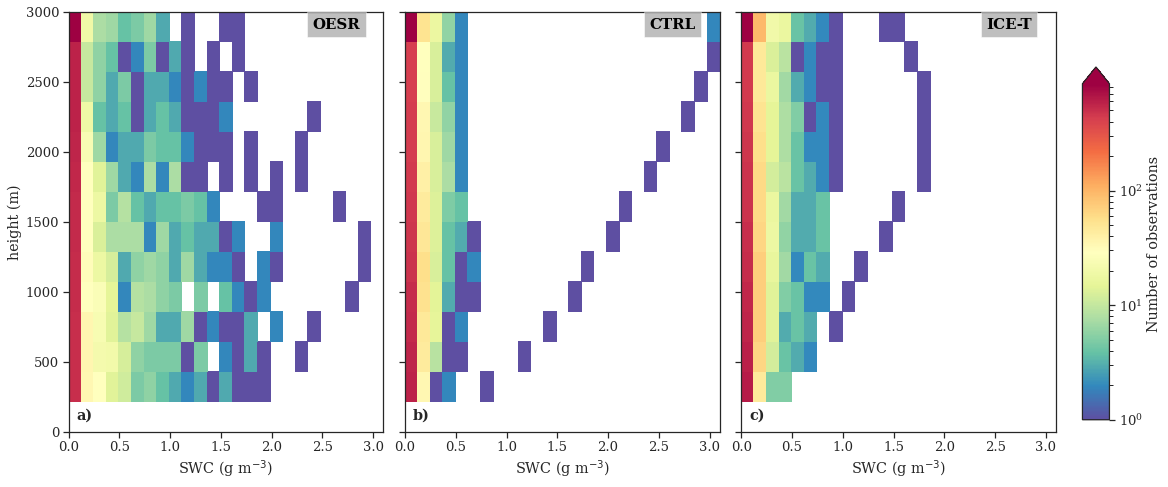

In [65]:
fig_label = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)']
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [15,7])
axs = axsm.flatten()
im = plt_SWC_hist2d(axs[0], _SWC[~np.isnan(_SWC)], _height[~np.isnan(_SWC)], 'OESR', bins =[25,14], range = [[0, 3.1], [0, 3000]],
                                           norm = mpl.colors.LogNorm(vmax=1000), 
                                           cmap = plt.get_cmap('Spectral').reversed());
im = plt_SWC_hist2d(axs[1], _SWC_c[~np.isnan(_SWC_c)], _height[~np.isnan(_SWC_c)], 'CTRL', bins =[25,14], range = [[0, 3.1], [0, 3000]],
                                           norm = mpl.colors.LogNorm(),
                                           cmap = plt.get_cmap('Spectral').reversed());
im = plt_SWC_hist2d(axs[2], _SWC_x[~np.isnan(_SWC_x)], _height[~np.isnan(_SWC_x)], 'ICE-T', bins =[25,14], range = [[0, 3.1], [0, 3000]],
                                           norm = mpl.colors.LogNorm(),
                                           cmap = plt.get_cmap('Spectral').reversed()
                                          );

    
cbar_ax = fig.add_axes([1.01, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend = 'max')
cbar.ax.set_ylabel('Number of observations')
axs[0].set(ylabel='height (m)');

for i in range(3):
    axs[i].text(0.05, 0.04,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
#axs[0].ticklabel_format(style='sci', axis='both', scilimits=(1,0))
plt.tight_layout()

if savefig == 1:
    fig_name = 'winter_16_17_SWC_2dhist.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [66]:
def plt_SWC_season_mean(ax, height, SWC, label, linestyle, label_sigma=None, color=None):
    ax.plot(np.nanmean(SWC, axis = 0), np.nanmean(height, axis = 0), label=label, linewidth=3, linestyle = linestyle,  color=color)#)
#    ax.fill_betweenx(np.nanmean(height, axis = 0) , 
 #                    np.nanmean(SWC, axis = 0)- np.nanstd(SWC, axis = 0),
  #                   np.nanmean(SWC, axis = 0)+ np.nanstd(SWC, axis = 0),
   #                  alpha=0.3, label=label_sigma, color = color, )
    ax.fill_betweenx(np.nanmean(height, axis = 0) , 
                     np.nanmean(SWC, axis = 0) - np.nanstd(_SWC[np.where(_SWC <np.nanmean(_SWC, axis = 0))[0],:], axis = 0),
                     np.nanmean(SWC, axis = 0) + np.nanstd(_SWC[np.where(_SWC >np.nanmean(_SWC, axis = 0))[0],:], axis = 0),
                     alpha=0.3, label=label_sigma, color = color, )

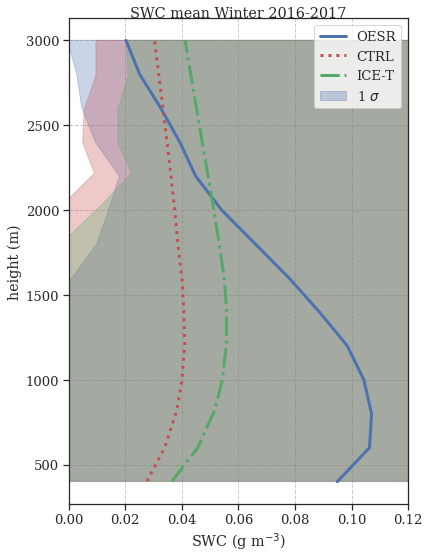

In [67]:
fig, axsm  = plt.subplots(1, 1, #sharex = 'all', 
                         # sharey = 'all',
                         figsize = [6,8])
plt_SWC_season_mean(axsm, height_SWC[meps][int(date[0])], _SWC,'OESR', '-' , '1 $\sigma$', 'b')
plt_SWC_season_mean(axsm, _height_c, _SWC_c, 'CTRL', ':', color = 'r')
plt_SWC_season_mean(axsm, _height_x, _SWC_x, 'ICE-T', '-.', color = 'g')

axsm.set(xlabel='SWC (g m$^{-3}$)', ylabel='height (m)')

axsm.legend(loc = 'upper right')
axsm.text(0.5, 1.01,
                'SWC mean Winter 2016-2017',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axsm.transAxes)
plt.subplots_adjust(wspace = 0.2, hspace=0.2);
plt.tight_layout()

#axsm.set_xlim([0,0.65])
axsm.set_xlim([0,0.12])

if savefig == 1:
    fig_name = 'winter_16_17_SWC_mean.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [68]:
def plt_vert_profile_median_std(ax, SWC, height, label = None, color = None, label_std = None):
    ax.plot(SWC.median(axis=0, skipna=True), 
            np.nanmedian(height, axis = 0), label = label, color = color)
#    ax.fill_betweenx(np.nanmedian(height, axis = 0), 
 #                    SWC.median(axis=0, skipna=True),
  #                   SWC.std(axis=0, skipna=True),
   #                  alpha = 0.3, color = color
    #                 )
    ax.plot(SWC.std(axis=0, skipna = True), np.nanmedian(height, axis = 0), color = color, linestyle = '--', label = label_std)

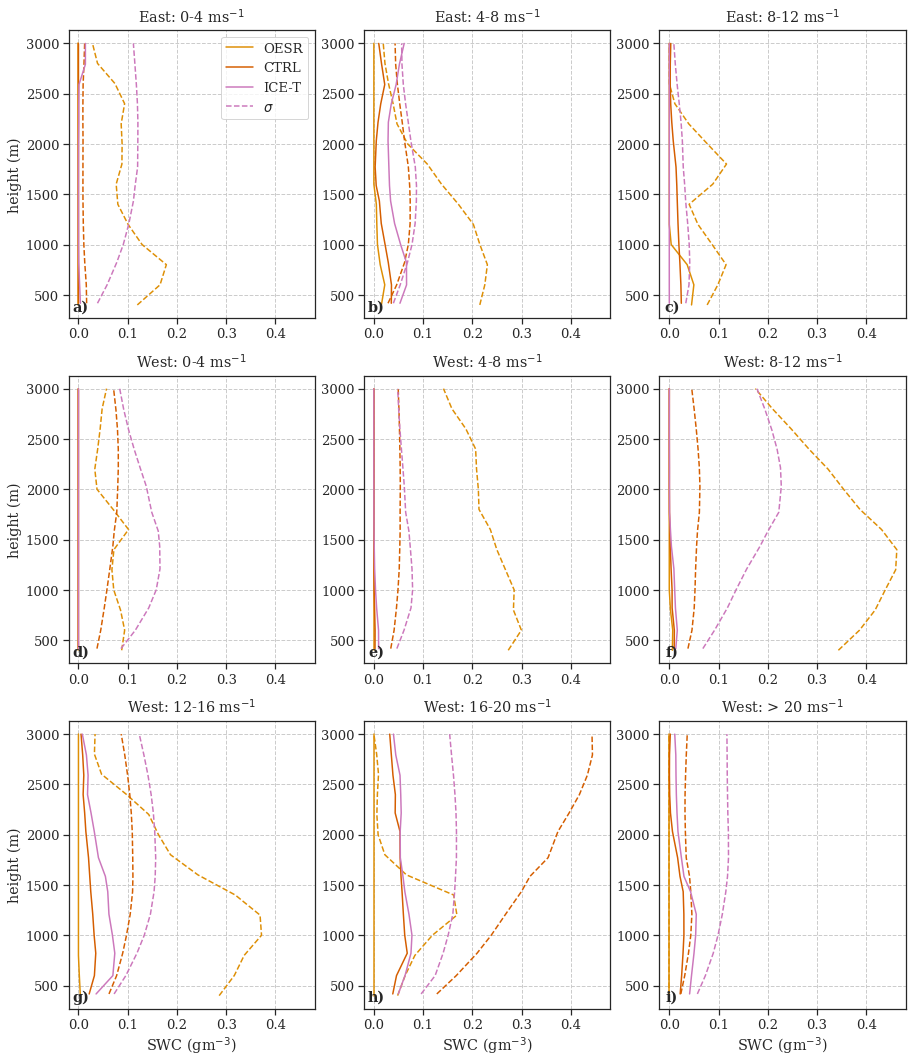

In [69]:
fig, axsm  = plt.subplots(3, 3, #sharex = 'all', 
                          #sharey = 'all',
                         figsize = [15,18])
axs = axsm.flatten()
for i in range(len(axs)):
    axs[i].text(0.05, 0.04,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
for i in np.arange(6,9):
    axs[i].set_xlabel('SWC (gm$^{-3}$)')
axs[0].set_ylabel('height (m)')
axs[3].set_ylabel('height (m)')
axs[6].set_ylabel('height (m)')


plt_vert_profile_median_std(axs[0], SWC_e_0_4, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_median_std(axs[0], SWC_MEPS_e_0_4['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[0], SWC_MEPS_e_0_4['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4],'$\sigma$')

axs[0].legend(loc = 'best')#'upper right')
axs[0].text(0.5, 1.05,
                'East: 0-4 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[0].transAxes)
axs[0].set_xlim([-0.02, 0.48])

##
plt_vert_profile_median_std(axs[1], SWC_e_4_8, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[1], SWC_MEPS_e_4_8['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[1], SWC_MEPS_e_4_8['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[1].text(0.5, 1.05,
                'East: 4-8 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[1].transAxes)
axs[1].set_xlim([-0.02, 0.48]);


##
plt_vert_profile_median_std(axs[2], SWC_e_8_12, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[2], SWC_MEPS_e_8_12['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[2], SWC_MEPS_e_8_12['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[2].text(0.5, 1.05,
                'East: 8-12 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[2].transAxes)
axs[2].set_xlim([-0.02, 0.48]);


##
plt_vert_profile_median_std(axs[3], SWC_w_0_4, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[3], SWC_MEPS_w_0_4['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[3], SWC_MEPS_w_0_4['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[3].text(0.5, 1.05,
                'West: 0-4 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[3].transAxes)
axs[3].set_xlim([-0.02, 0.48]);

##
plt_vert_profile_median_std(axs[4], SWC_w_4_8, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[4], SWC_MEPS_w_4_8['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[4], SWC_MEPS_w_4_8['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[4].text(0.5, 1.05,
                'West: 4-8 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[4].transAxes)
axs[4].set_xlim([-0.02, 0.48]);

##
plt_vert_profile_median_std(axs[5], SWC_w_8_12, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[5], SWC_MEPS_w_8_12['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[5], SWC_MEPS_w_8_12['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[5].text(0.5, 1.05,
                'West: 8-12 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[5].transAxes)
axs[5].set_xlim([-0.02, 0.48]);

##
plt_vert_profile_median_std(axs[6], SWC_w_12_16, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[6], SWC_MEPS_w_12_16['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[6], SWC_MEPS_w_12_16['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[6].text(0.5, 1.05,
                'West: 12-16 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[6].transAxes)
axs[6].set_xlim([-0.02, 0.48]);

##
plt_vert_profile_median_std(axs[7], SWC_w_16_20, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[7], SWC_MEPS_w_16_20['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[7], SWC_MEPS_w_16_20['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[7].text(0.5, 1.05,
                'West: 16-20 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[7].transAxes)
axs[7].set_xlim([-0.02, 0.48]);

##
plt_vert_profile_median_std(axs[8], SWC_w_20, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1])
plt_vert_profile_median_std(axs[8], SWC_MEPS_w_20['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[8], SWC_MEPS_w_20['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])
axs[8].text(0.5, 1.05,
                'West: > 20 ms$^{-1}$',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[8].transAxes)
axs[8].set_xlim([-0.02, 0.48]);



if savefig == 1:
    fig_name = 'winter_16_17_WD_WS_SWC_median_std.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [70]:
_swc_e = pd.concat([SWC_e_0_4, SWC_e_4_8, SWC_e_8_12, SWC_e_12_16, SWC_e_16_20, SWC_e_20]).reset_index(drop = True)
_swc_w = pd.concat([SWC_w_0_4, SWC_w_4_8, SWC_w_8_12, SWC_w_12_16, SWC_w_16_20, SWC_w_20]).reset_index(drop = True)

_swc_t = pd.concat([SWC_e_0_4, SWC_e_4_8, SWC_e_8_12, SWC_e_12_16, SWC_e_16_20, SWC_e_20,
                    SWC_w_0_4, SWC_w_4_8, SWC_w_8_12, SWC_w_12_16, SWC_w_16_20, SWC_w_20]).reset_index(drop = True)


In [71]:
_swc_meps_e = dict()
_swc_meps_w = dict()
_swc_meps_t = dict()
for meps in meps_run:
    _swc_meps_e[meps] = pd.concat([SWC_MEPS_e_0_4[meps], SWC_MEPS_e_4_8[meps], SWC_MEPS_e_8_12[meps], SWC_MEPS_e_12_16[meps], SWC_MEPS_e_16_20[meps], SWC_MEPS_e_20[meps]]).reset_index(drop = True)
    _swc_meps_w[meps] = pd.concat([SWC_MEPS_w_0_4[meps], SWC_MEPS_w_4_8[meps], SWC_MEPS_w_8_12[meps], SWC_MEPS_w_12_16[meps], SWC_MEPS_w_16_20[meps], SWC_MEPS_w_20[meps]]).reset_index(drop = True)
    
    _swc_meps_t[meps] = pd.concat([SWC_MEPS_e_0_4[meps], SWC_MEPS_e_4_8[meps], SWC_MEPS_e_8_12[meps], SWC_MEPS_e_12_16[meps], SWC_MEPS_e_16_20[meps], SWC_MEPS_e_20[meps],
                                   SWC_MEPS_w_0_4[meps], SWC_MEPS_w_4_8[meps], SWC_MEPS_w_8_12[meps], SWC_MEPS_w_12_16[meps], SWC_MEPS_w_16_20[meps], SWC_MEPS_w_20[meps]]).reset_index(drop = True)


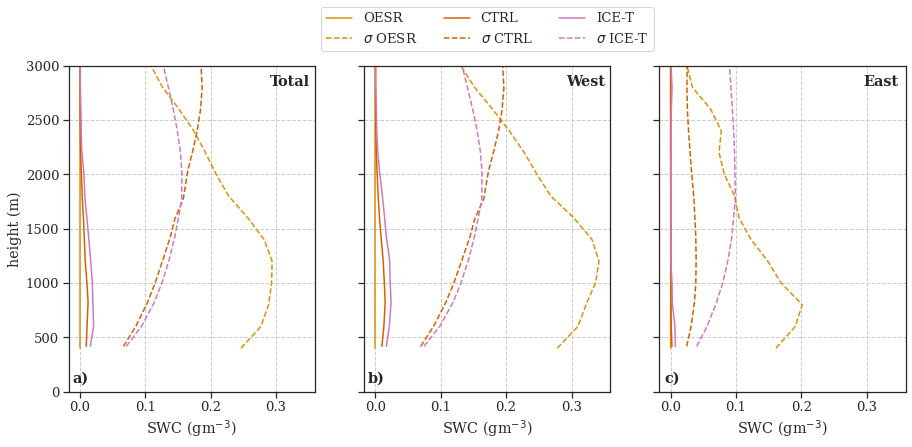

In [72]:
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [15,6])
axs = axsm.flatten()
for i in range(len(axs)):
    axs[i].text(0.05, 0.04,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
for i in np.arange(3):
    axs[i].set_xlabel('SWC (gm$^{-3}$)')
axs[0].set_ylabel('height (m)')
axs[0].set_ylim([0, 3000])

### total
plt_vert_profile_median_std(axs[0], _swc_t, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_median_std(axs[0], _swc_meps_t['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_median_std(axs[0], _swc_meps_t['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])

axs[0].text(0.9, .95,
                'Total',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[0].transAxes);


    
### West
plt_vert_profile_median_std(axs[1], _swc_w, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], '$\sigma$ OESR')
plt_vert_profile_median_std(axs[1], _swc_meps_w['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3], '$\sigma$ CTRL')
plt_vert_profile_median_std(axs[1], _swc_meps_w['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4], '$\sigma$ ICE-T')

axs[1].text(0.9, .95,
                'West',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[1].transAxes);
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3);


### East
plt_vert_profile_median_std(axs[2], _swc_e, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_median_std(axs[2], _swc_meps_e['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_median_std(axs[2], _swc_meps_e['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4], )

axs[2].text(0.9, .95,
                'East',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[2].transAxes);

if savefig == 1:
    fig_name = 'winter_16_17_SWC_median_std.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [73]:
def plt_vert_profile_mean_std(ax, SWC, height, label = None, color = None, label_std = None):
    ax.plot(SWC.mean(axis=0, skipna=True), 
            np.nanmedian(height, axis = 0), label = label, color = color)
#    ax.fill_betweenx(np.nanmedian(height, axis = 0), 
 #                    SWC.median(axis=0, skipna=True),
  #                   SWC.std(axis=0, skipna=True),
   #                  alpha = 0.3, color = color
    #                 )
    ax.plot(SWC.std(axis=0, skipna = True), np.nanmedian(height, axis = 0), color = color, linestyle = '--', label = label_std)

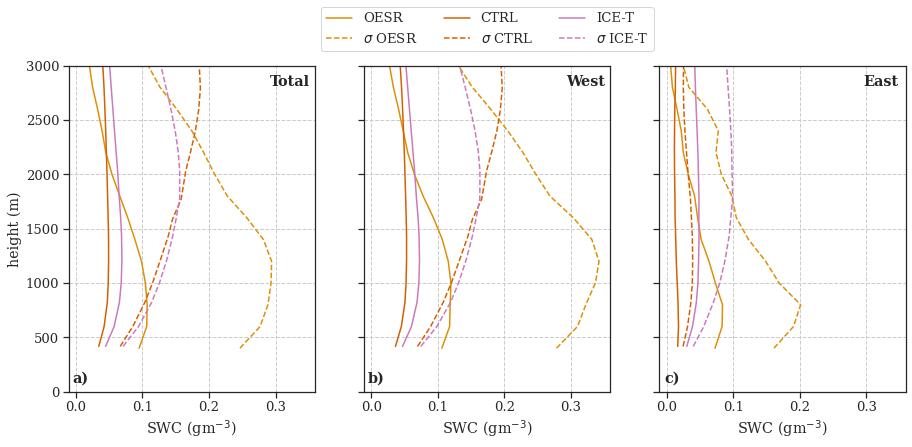

In [74]:
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [15,6])
axs = axsm.flatten()
for i in range(len(axs)):
    axs[i].text(0.05, 0.04,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
for i in np.arange(3):
    axs[i].set_xlabel('SWC (gm$^{-3}$)')
axs[0].set_ylabel('height (m)')
axs[0].set_ylim([0, 3000])

### total
plt_vert_profile_mean_std(axs[0], _swc_t, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[0], _swc_meps_t['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3])
plt_vert_profile_mean_std(axs[0], _swc_meps_t['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4])

axs[0].text(0.9, .95,
                'Total',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[0].transAxes);


    
### West
plt_vert_profile_mean_std(axs[1], _swc_w, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], '$\sigma$ OESR')
plt_vert_profile_mean_std(axs[1], _swc_meps_w['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3], '$\sigma$ CTRL')
plt_vert_profile_mean_std(axs[1], _swc_meps_w['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4], '$\sigma$ ICE-T')

axs[1].text(0.9, .95,
                'West',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[1].transAxes);
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3);


### East
plt_vert_profile_mean_std(axs[2], _swc_e, height_SWC[meps][int(date[0])], 'OESR', sns.color_palette("colorblind",5)[1], )
plt_vert_profile_mean_std(axs[2], _swc_meps_e['CTRL'], _height_c, 'CTRL', sns.color_palette("colorblind",5)[3], )
plt_vert_profile_mean_std(axs[2], _swc_meps_e['ICE-T'], _height_x, 'ICE-T', sns.color_palette("colorblind",5)[4], )

axs[2].text(0.9, .95,
                'East',
                fontweight = 'bold',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[2].transAxes);

if savefig == 1:
    fig_name = 'winter_16_17_SWC_mean_std.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [33]:
obs_precip_west_ws = [np.nanmean(vals_west_0_4, axis = 0)[1], 
                      np.nanmean(vals_west_4_8, axis = 0)[1], 
                      np.nanmean(vals_west_8_12, axis = 0)[1], 
                      np.nanmean(vals_west_12_16, axis = 0)[1], 
                      np.nanmean(vals_west_16_20, axis = 0)[1], 
                      np.nanmean(vals_west_20, axis = 0)[1], ]
obs_precip_west_ws = np.array(obs_precip_west_ws)
#obs_precip_west_ws[np.where(obs_precip_west_ws[:] == 0.)] = np.nan

obs_precip_east_ws = [np.nanmean(vals_east_0_4, axis = 0)[1], 
                      np.nanmean(vals_east_4_8, axis = 0)[1], 
                      np.nanmean(vals_east_8_12, axis = 0)[1], 
                      np.nanmean(vals_east_12_16, axis = 0)[1], 
                      np.nanmean(vals_east_16_20, axis = 0)[1], 
                      np.nanmean(vals_east_20, axis = 0)[1]]
obs_precip_east_ws = np.array(obs_precip_east_ws)
#obs_precip_east_ws[np.where(obs_precip_east_ws[:] == 0.)] = np.nan

meps_precip_west_ws = dict()
meps_precip_east_ws = dict()
for meps in meps_run:
    meps_precip_west_ws[meps] = [np.nanmean(vals_MEPS_west_0_4[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_west_4_8[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_west_8_12[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_west_12_16[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_west_16_20[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_west_20[meps], axis = 0)[1], ]
    meps_precip_west_ws[meps] = np.array(meps_precip_west_ws[meps])
#    meps_precip_west_ws[meps][np.where(meps_precip_west_ws[meps][:] == 0.)] = np.nan
    
    meps_precip_east_ws[meps] = [np.nanmean(vals_MEPS_east_0_4[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_east_4_8[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_east_8_12[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_east_12_16[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_east_16_20[meps], axis = 0)[1], 
                      np.nanmean(vals_MEPS_east_20[meps], axis = 0)[1], ]
    meps_precip_east_ws[meps] = np.array(meps_precip_east_ws[meps])
#    meps_precip_east_ws[meps][np.where(meps_precip_east_ws[meps][:] == 0.)] = np.nan

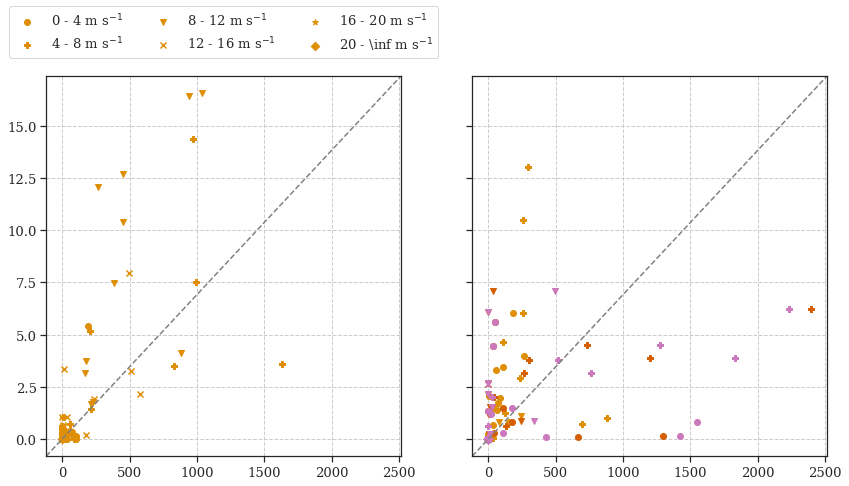

In [127]:
fig, axsm  = plt.subplots(1, 2, sharex = 'all', 
                          sharey = 'all',
                         figsize = [14,7])
axs = axsm.flatten()

axs[0].scatter(vals_west_0_4[:,1], ret_precip_west_0_4[:,1], marker = 'o', color = sns.color_palette("colorblind",5)[1], label = '0 - 4 m s$^{-1}$' )
axs[0].scatter(vals_west_4_8[:,1], ret_precip_west_4_8[:,1], marker = 'P', color = sns.color_palette("colorblind",5)[1], label = '4 - 8 m s$^{-1}$')
axs[0].scatter(vals_west_8_12[:,1], ret_precip_west_8_12[:,1], marker = 'v', color = sns.color_palette("colorblind",5)[1], label = '8 - 12 m s$^{-1}$')
axs[0].scatter(vals_west_12_16[:,1], ret_precip_west_12_16[:,1], marker = 'x', color = sns.color_palette("colorblind",5)[1], label = '12 - 16 m s$^{-1}$')
axs[0].scatter(vals_west_16_20[:,1], ret_precip_west_16_20[:,1], marker = '*', color = sns.color_palette("colorblind",5)[1], label = '16 - 20 m s$^{-1}$')
axs[0].scatter(vals_west_20[:,1], ret_precip_west_20[:,1], marker = 'D', color = sns.color_palette("colorblind",5)[1], label = '20 - \inf m s$^{-1}$')

axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3);


#for i, meps in zip(np.arange(3,5) , meps_run):
 #   axs[0].scatter(vals_MEPS_west_0_4[meps][:,1], meps_precip_west_0_4[:,1], marker = 'o', color = sns.color_palette("colorblind",5)[i])
  #  axs[0].scatter(vals_MEPS_west_4_8[meps][:,1], meps_precip_west_4_8[:,1], marker = 'P', color = sns.color_palette("colorblind",5)[i])
   # axs[0].scatter(vals_MEPS_west_8_12[meps][:,1], meps_precip_west_8_12[:,1], marker = 'v', color = sns.color_palette("colorblind",5)[i])
    #axs[0].scatter(vals_MEPS_west_12_16[meps][:,1], meps_precip_west_12_16[:,1], marker = 'x', color = sns.color_palette("colorblind",5)[i])
#    axs[0].scatter(vals_MEPS_west_16_20[meps][:,1], meps_precip_west_16_20[:,1], marker = '*', color = sns.color_palette("colorblind",5)[i])
 #   axs[0].scatter(vals_MEPS_west_20[meps][:,1], meps_precip_west_20[:,1], marker = 'D', color = sns.color_palette("colorblind",5)[i])

axs[1].scatter(vals_east_0_4[:,1], ret_precip_east_0_4[:,1], marker = 'o', color = sns.color_palette("colorblind",5)[1], label = '0 - 4 m s$^{-1}$' )
axs[1].scatter(vals_east_4_8[:,1], ret_precip_east_4_8[:,1], marker = 'P', color = sns.color_palette("colorblind",5)[1], label = '4 - 8 m s$^{-1}$')
axs[1].scatter(vals_east_8_12[:,1], ret_precip_east_8_12[:,1], marker = 'v', color = sns.color_palette("colorblind",5)[1], label = '8 - 12 m s$^{-1}$')
axs[1].scatter(vals_east_12_16[:,1], ret_precip_east_12_16[:,1], marker = 'x', color = sns.color_palette("colorblind",5)[1], label = '12 - 16 m s$^{-1}$')
axs[1].scatter(vals_east_16_20[:,1], ret_precip_east_16_20[:,1], marker = '*', color = sns.color_palette("colorblind",5)[1], label = '16 - 20 m s$^{-1}$')
axs[1].scatter(vals_east_20[:,1], ret_precip_east_20[:,1], marker = 'D', color = sns.color_palette("colorblind",5)[1], label = '20 - \inf m s$^{-1}$')
#axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol = 3);


for i, meps in zip(np.arange(3,5) , meps_run):
    axs[1].scatter(vals_MEPS_east_0_4[meps][:,1], meps_precip_east_0_4[:,1], marker = 'o', color = sns.color_palette("colorblind",5)[i])
    axs[1].scatter(vals_MEPS_east_4_8[meps][:,1], meps_precip_east_4_8[:,1], marker = 'P', color = sns.color_palette("colorblind",5)[i])
    axs[1].scatter(vals_MEPS_east_8_12[meps][:,1], meps_precip_east_8_12[:,1], marker = 'v', color = sns.color_palette("colorblind",5)[i])
    axs[1].scatter(vals_MEPS_east_12_16[meps][:,1], meps_precip_east_12_16[:,1], marker = 'x', color = sns.color_palette("colorblind",5)[i])
    axs[1].scatter(vals_MEPS_east_16_20[meps][:,1], meps_precip_east_16_20[:,1], marker = '*', color = sns.color_palette("colorblind",5)[i])
    axs[1].scatter(vals_MEPS_east_20[meps][:,1], meps_precip_east_20[:,1], marker = 'D', color = sns.color_palette("colorblind",5)[i])

for i in range(len(axs)):
        axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls='--', color='grey')


#vals_MEPS_east_0_4

In [34]:
# confidence intervals
obs_swp_std_west_ws = [np.nanstd(vals_west_0_4, axis = 0)[1], 
                      np.nanstd(vals_west_4_8, axis = 0)[1], 
                      np.nanstd(vals_west_8_12, axis = 0)[1], 
                      np.nanstd(vals_west_12_16, axis = 0)[1], 
                      np.nanstd(vals_west_16_20, axis = 0)[1], 
                      np.nanstd(vals_west_20, axis = 0)[1], ]
obs_swp_std_west_ws = np.array(obs_swp_std_west_ws)
#obs_precip_west_ws[np.where(obs_precip_west_ws[:] == 0.)] = np.nan

obs_swp_std_east_ws = [np.nanstd(vals_east_0_4, axis = 0)[1], 
                      np.nanstd(vals_east_4_8, axis = 0)[1], 
                      np.nanstd(vals_east_8_12, axis = 0)[1], 
                      np.nanstd(vals_east_12_16, axis = 0)[1], 
                      np.nanstd(vals_east_16_20, axis = 0)[1], 
                      np.nanstd(vals_east_20, axis = 0)[1]]
obs_swp_std_east_ws = np.array(obs_swp_std_east_ws)
#obs_precip_east_ws[np.where(obs_precip_east_ws[:] == 0.)] = np.nan

meps_swp_std_west_ws = dict()
meps_swp_std_east_ws = dict()
for meps in meps_run:
    meps_swp_std_west_ws[meps] = [np.nanstd(vals_MEPS_west_0_4[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_west_4_8[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_west_8_12[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_west_12_16[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_west_16_20[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_west_20[meps], axis = 0)[1], ]
    meps_swp_std_west_ws[meps] = np.array(meps_swp_std_west_ws[meps])
#    meps_precip_west_ws[meps][np.where(meps_precip_west_ws[meps][:] == 0.)] = np.nan
    
    meps_swp_std_east_ws[meps] = [np.nanstd(vals_MEPS_east_0_4[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_east_4_8[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_east_8_12[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_east_12_16[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_east_16_20[meps], axis = 0)[1], 
                      np.nanstd(vals_MEPS_east_20[meps], axis = 0)[1], ]
    meps_swp_std_east_ws[meps] = np.array(meps_swp_std_east_ws[meps])
#    meps_precip_east_ws[meps][np.where(meps_precip_east_ws[meps][:] == 0.)] = np.nan

In [35]:
def plt_SWP_in_wind_category(axs, west_ws, east_ws, observation):
    
    bar_width = 0.35
    opacity = 0.4
    
    bar11 = axs.bar(np.arange(west_ws.shape[0]) - bar_width/2,
                       west_ws[:], width = bar_width,
                       align = 'center', alpha = opacity, color = 'b', 
                       label = 'westerlies {:.2e}'.format(np.nansum(west_ws[:])))
    bar12 = axs.bar(np.arange(east_ws.shape[0]) + bar_width/2,
                       east_ws[:], width = bar_width,
                       align = 'center', alpha = opacity, color = 'r', 
                       label = 'easterlies {:.2e}'.format(np.nansum(east_ws[:])))
    axs.text(0.92, 0.93, observation ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs.transAxes,
        color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})

    # Add counts above the two bar graphs
    for rect in bar11 + bar12:
        height = rect.get_height()
        if np.isnan(height):
            continue
        else:
            axs.text(rect.get_x() + rect.get_width()/2.0, height, '{:.2e}'.format(height), ha='center', va='bottom')
    axs.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',fancybox=True, facecolor ='white')

    
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)



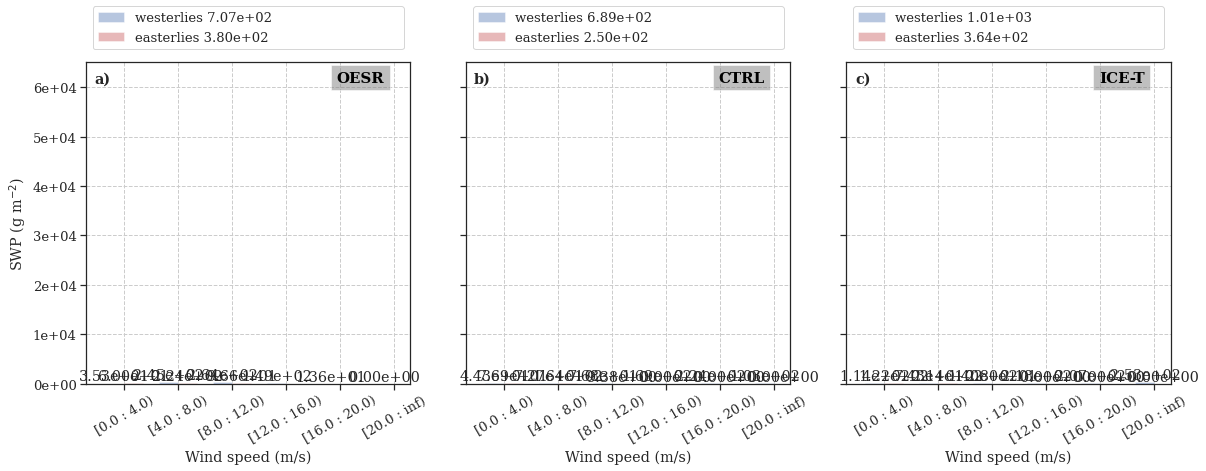

In [36]:
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [17,6.8])
axs = axsm.flatten()

for i in range(axs.shape[0]):
    axs[i].set_xlabel('Wind speed (m/s)')
axs[0].set_ylabel('SWP (g m$^{-2}$)')
y_labels = axs[0].get_yticks()
axs[0].set_ylim([0,6.5*10**4])
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))
axs[0].set_xlim([0-0.7,6-0.7])

plt_SWP_in_wind_category(axs[0], obs_precip_west_ws, obs_precip_east_ws, 'OESR')
for i, meps in zip(np.arange(1,np.array(meps_run).shape[0]+1), meps_run):
    plt_SWP_in_wind_category(axs[i], meps_precip_west_ws[meps], meps_precip_east_ws[meps], '%s' %(meps))

for i in range(3):
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWP_WS_WD.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [37]:
def plt_SWP_in_wind_category_V2(axs, west_ws, observation, wd):
    
    bar_width = 0.35
    opacity = 0.4
    
    if wd == 'west':
        bar11 = axs.bar(np.arange(west_ws.shape[0]) - bar_width/2,
                       west_ws[:], width = bar_width,
                       align = 'center', alpha = opacity, color = 'b', 
                       label = 'westerlies {:.2e}'.format(np.nansum(west_ws[:])))
    if wd == 'east':
        bar11 = axs.bar(np.arange(west_ws.shape[0]) + bar_width/2,
                       west_ws[:], width = bar_width,
                       align = 'center', alpha = opacity, color = 'r', 
                       label = 'easterlies {:.2e}'.format(np.nansum(west_ws[:])))
    axs.text(0.92, 0.93, observation ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs.transAxes,
        color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})

    # Add counts above the two bar graphs
    for rect in bar11:# + bar12:
        height = rect.get_height()
        if np.isnan(height):
            continue
        else:
            axs.text(rect.get_x() + rect.get_width()/2.0, height, '{:.2e}'.format(height), ha='center', va='bottom')
    axs.legend(bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', mode='expand',fancybox=True, facecolor ='white')

    
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'], rotation=30)



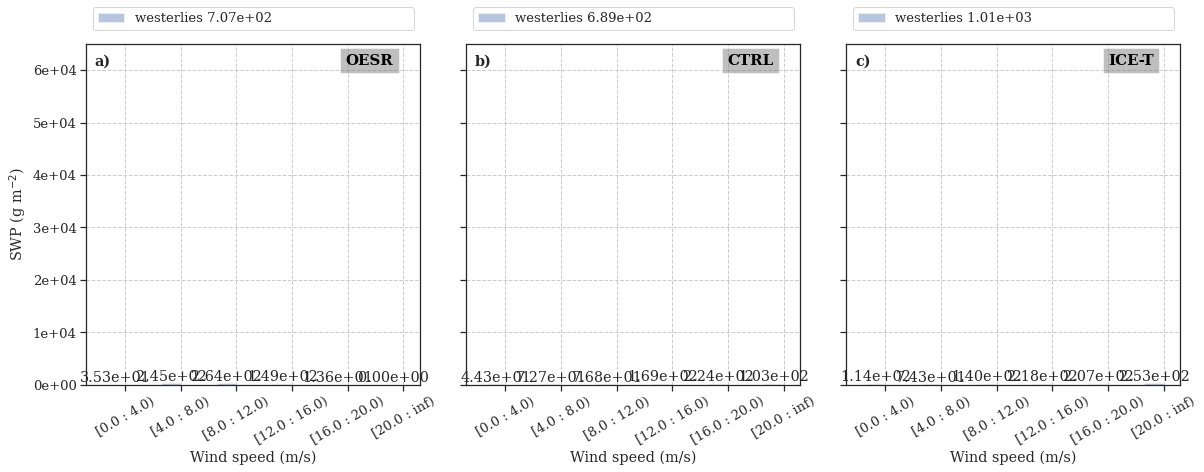

In [38]:
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [17,6.8])
axs = axsm.flatten()

for i in range(axs.shape[0]):
    axs[i].set_xlabel('Wind speed (m/s)')
axs[0].set_ylabel('SWP (g m$^{-2}$)')
y_labels = axs[0].get_yticks()
axs[0].set_ylim([0,6.5*10**4])
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))
axs[0].set_xlim([0-0.7,6-0.7])

plt_SWP_in_wind_category_V2(axs[0], obs_precip_west_ws, 
                            #obs_precip_east_ws, 
                            'OESR', 'west')
for i, meps in zip(np.arange(1,np.array(meps_run).shape[0]+1), meps_run):
    plt_SWP_in_wind_category_V2(axs[i], meps_precip_west_ws[meps], 
                                #meps_precip_east_ws[meps], 
                                '%s' %(meps), 'west')

for i in range(3):
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWP_WS_WD_westerlies.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

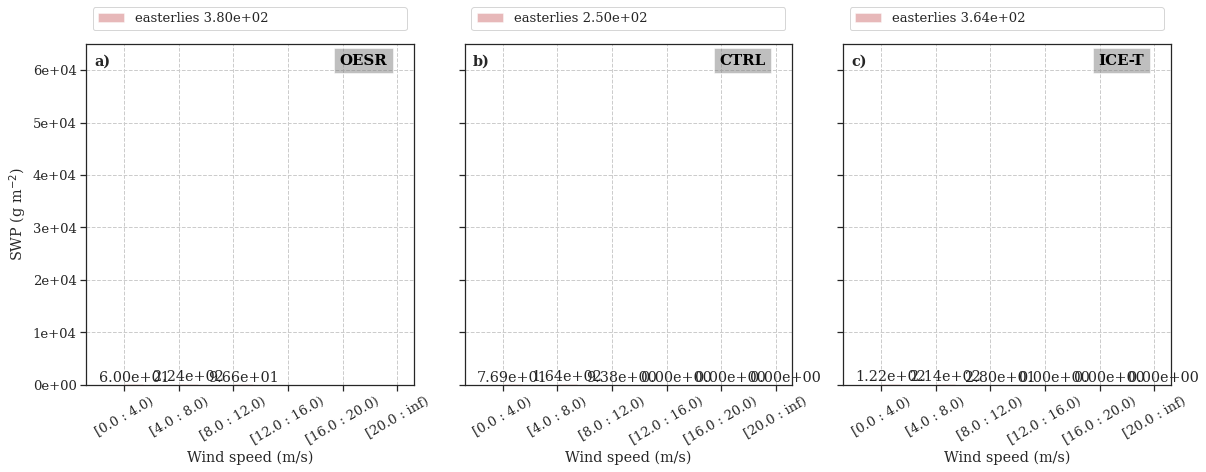

In [39]:
fig, axsm  = plt.subplots(1, 3, sharex = 'all', 
                          sharey = 'all',
                         figsize = [17,6.8])
axs = axsm.flatten()

for i in range(axs.shape[0]):
    axs[i].set_xlabel('Wind speed (m/s)')
axs[0].set_ylabel('SWP (g m$^{-2}$)')
y_labels = axs[0].get_yticks()
axs[0].set_ylim([0,6.5*10**4])
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
axs[0].set_xticks(np.arange(obs_precip_west_ws.shape[0]))
axs[0].set_xlim([0-0.7,6-0.7])

plt_SWP_in_wind_category_V2(axs[0], #obs_precip_west_ws, 
                            obs_precip_east_ws, 
                            'OESR', 'east')
for i, meps in zip(np.arange(1,np.array(meps_run).shape[0]+1), meps_run):
    plt_SWP_in_wind_category_V2(axs[i], #meps_precip_west_ws[meps], 
                                meps_precip_east_ws[meps], 
                                '%s' %(meps), 'east')

for i in range(3):
    axs[i].text(0.05, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
plt.tight_layout()
if savefig == 1:
    fig_name = 'winter_16_17_SWP_WS_WD_easterlies.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
    plt.close()

In [40]:
def plt_bar_obs_ret_meps(axs, west, west_std, x, observation, color = None):
    bar_width = 0.23
    opacity = 0.8
    
    y_r = [west[i] - west_std[i] for i in range(len(west_std))]
    bar = axs.bar(np.arange(len(west)) + x*bar_width,
                       west[:], width = bar_width,
                      yerr=y_r,
                       align = 'center', alpha = opacity, color = color, 
            #           label = '{:}: {:.1f} mm'.format(observation,np.nansum(west[:]))
                 
                 label = '{:}: {:.1f} g/m2'.format(observation,np.nanmean(west[:])))
    

    axs.set_xticks(np.arange(len(west)))
    axs.set_xticklabels(['[0.0 : 4.0)', '[4.0 : 8.0)', '[8.0 : 12.0)', '[12.0 : 16.0)', '[16.0 : 20.0)', '[20.0 : inf)'],                         rotation=20)
    axs.set_xlabel('Wind speed (m/s)')

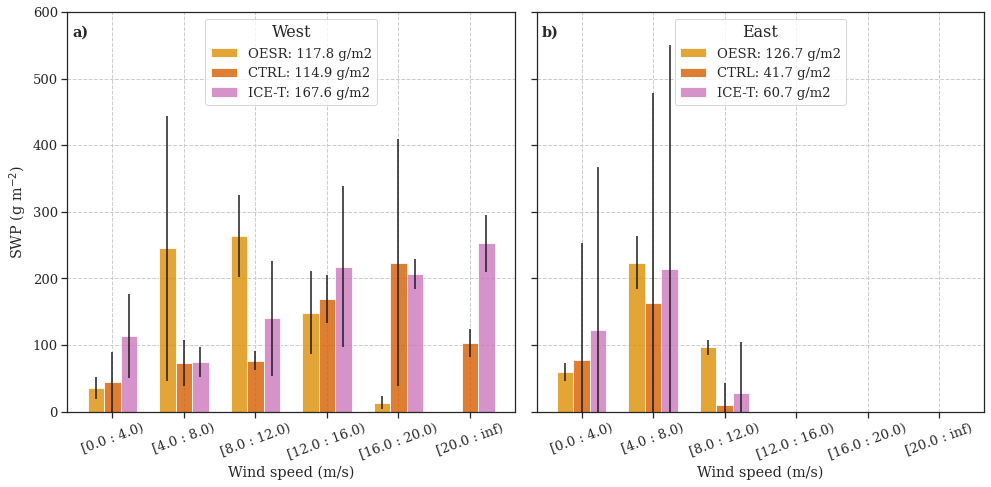

In [41]:
fig, axsm = plt.subplots(1, 2, sharex = 'all', 
                              sharey = 'all',
                             figsize = [14,7])

axs = axsm.flatten()

# easterlies
plt_bar_obs_ret_meps(axs[1], obs_precip_east_ws, obs_swp_std_east_ws, -1, 'OESR', color = sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws['CTRL'], meps_swp_std_east_ws['CTRL'], 0, 'CTRL', color = sns.color_palette("colorblind",5)[3])

plt_bar_obs_ret_meps(axs[1], meps_precip_east_ws['ICE-T'],meps_swp_std_east_ws['ICE-T'], +1, 'ICE-T', color = sns.color_palette("colorblind",5)[4])
axs[1].legend(loc = 'upper center',#bbox_to_anchor=(0,.92,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'East', title_fontsize=16)
axs[1].set_ylim([0,600])

# westerlies
plt_bar_obs_ret_meps(axs[0], obs_precip_west_ws, obs_swp_std_west_ws, -1, 'OESR', color = sns.color_palette("colorblind",5)[1])
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws['CTRL'], meps_swp_std_west_ws['CTRL'], 0, 'CTRL', color = sns.color_palette("colorblind",5)[3])
plt_bar_obs_ret_meps(axs[0], meps_precip_west_ws['ICE-T'], meps_swp_std_west_ws['ICE-T'], +1, 'ICE-T', color = sns.color_palette("colorblind",5)[4])
axs[0].legend(loc = 'upper center', #bbox_to_anchor=(0,1.02,1,0.2), loc='lower left', #mode='expand',
              fancybox=True, facecolor ='white', title = 'West', title_fontsize=16)
axs[0].set_ylabel('SWP (g m$^{-2}$)')


for i in range(2):
    axs[i].text(0.03, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)

plt.tight_layout()

if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'winter_16_17_SWP_WS_WD_V2.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

In [42]:
from pymeteo import radar

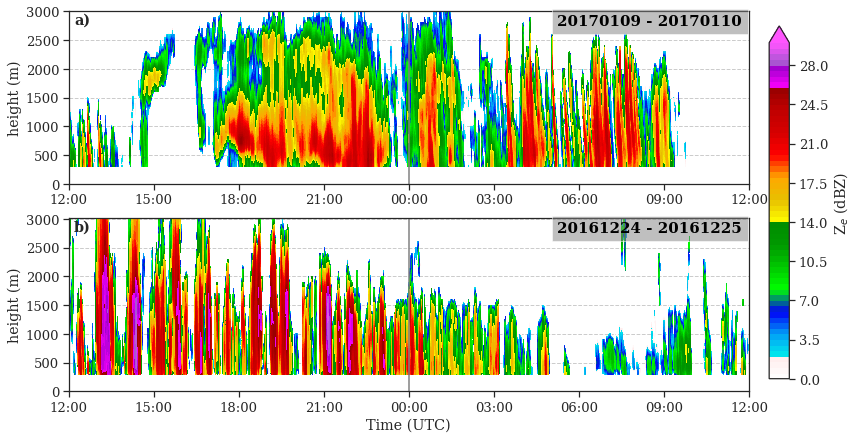

In [43]:
### Plot MRR reflectivity for east study case (09/01) and west study case (24/12)
# https://github.com/cwebster2/pyMeteo/blob/master/pymeteo/radar.py
fig, axsm = plt.subplots(2, 1, #sharex = 'all', 
                             # sharey = 'all',
                             figsize = [14,7])

axs = axsm.flatten()
# MRR reflectivity
_mrr = axs[0].contourf(time_ret['CTRL'][20170109], height_MRR['CTRL'][20170109][0,:],np.transpose(Ze['CTRL'][20170109]),
                                        #   levels = np.arange(-10,30.1,0.5),
                                        levels = np.arange(0,30,0.5),
                                        vmin = 0., vmax = 30.,
                                        cmap = plt.get_cmap('pymeteo_radar'),#'plasma',
                                        extend = 'max',)
axs[0].text(0.99, 0.9, '20170109 - 20170110' ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs[0].transAxes,
        color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})

_mrr = axs[1].contourf(time_ret['CTRL'][20161224], height_MRR['CTRL'][20161224][0,:],np.transpose(Ze['CTRL'][20161224]),
                                       # levels=radar.cmap_radar_levels(),#
                                        levels = np.arange(0.,30.5,0.5),
                                        vmin = 0., vmax = 30.,
                                        cmap = plt.get_cmap('pymeteo_radar'),#'plasma',
                                        extend = 'max',)

axs[1].text(0.99, 0.9, '20161224 - 20161225' ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axs[1].transAxes,
        color='black', fontsize=15, fontweight='bold', bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5.5})
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
_mrr_bar = fig.colorbar(_mrr, cax=cbar_ax, shrink=0.9)


_mrr_bar.ax.set_ylabel('Z$_{e}$ (dBZ)')


for i in range(2):#axs.shape[0]):
                        axs[i].set_ylabel('height (m)')
                        axs[i].xaxis.grid()
                        axs[i].axvline(4*180, color = 'grey', linewidth = 1.5)
                        axs[i].axis([0., 1440, 0., 3010])
                        axs[i].set_yticks(np.arange(0,3010,500))
                        axs[i].set_xticks(np.arange(0,1620,180))
                        axs[i].set_xticklabels(['12:00', '15:00', '18:00', '21:00', 
                                                '00:00', '03:00', '06:00', '09:00', '12:00',],#rotation = 25.
                                              )
                        
                        axs[i].text(0.02, 0.95,
                    fig_label[i],
                    fontweight='bold',
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform = axs[i].transAxes)
axs[1].set_xlabel('Time (UTC)');

if savefig == 1:
        cF.createFolder('%s/' %(figdir))
        fig_name = 'MRR_20170109_20161224.'+form
        plt.savefig('%s/%s' %(figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
        print('plot saved: %s/%s' %(figdir, fig_name))
        plt.close()

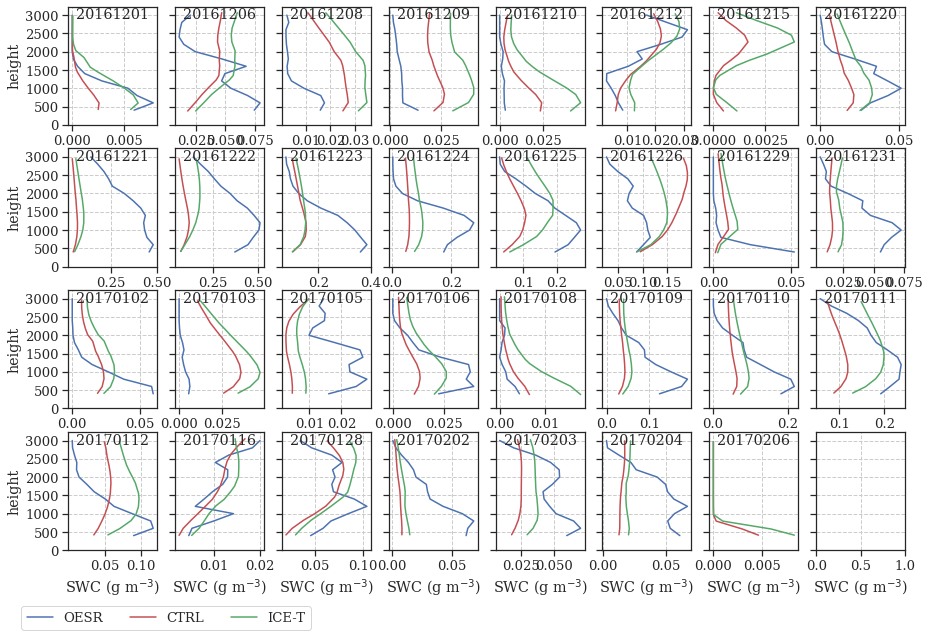

In [44]:
fig, axsm  = plt.subplots(4, 8, #sharex = 'all', 
                          sharey = 'all',
                         figsize = [15,10])
axs = axsm.flatten()
for Date, i in zip(date, np.arange(date.shape[0])):
    axs[i].plot(np.mean(SWC[meps][Date], axis = 0), height_SWC[meps][Date][0,:],label='OESR', color ='b')
    axs[i].plot(np.mean(SWC_MEPS['CTRL'][Date][12:,:], axis = 0), 
                np.mean(height_MEPS['CTRL'][Date][12:,:], axis = 0), label='CTRL', color ='r')
    axs[i].plot(np.mean(SWC_MEPS['ICE-T'][Date][12:,:], axis = 0),
                np.mean(height_MEPS['ICE-T'][Date][12:,:], axis = 0), label='ICE-T', color ='g')
    axs[i].text(0.5, 0.93,
                int(Date),
                horizontalalignment='center',
                verticalalignment='center',
                transform = axs[i].transAxes)

for ax in axsm.flat:
    ax.set(xlabel='SWC (g m$^{-3}$)', ylabel='height')
    ax.set_yticks(np.arange(0,3100,500))
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axsm.flat:
 #   ax.label_outer()
for i, k, l, m in zip(range(1,8), range(9,16), range(17, 24), range(25,32)):
    axs[i].yaxis.label.set_visible(False)
    axs[k].yaxis.label.set_visible(False)
    axs[l].yaxis.label.set_visible(False)
    axs[m].yaxis.label.set_visible(False)
    
for i in range(0,24):
    axs[i].xaxis.label.set_visible(False)
    
#Get the lengend handles and labels
h1, l1 = axs[0].get_legend_handles_labels()
#Make the legend
axs[0].legend(h1, l1,  
              #bbox_to_anchor=(0,-.05, 2.2,-0.15), 
              bbox_to_anchor=(0.6, -4.12, 1., .102),
              loc=9,
           ncol=4)

plt.subplots_adjust(wspace = 0.2, hspace=0.2);
plt.tight_layout()

if savefig == 1:
    fig_name = 'winter_16_17_SWC_daily_mean.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
#plt.close()

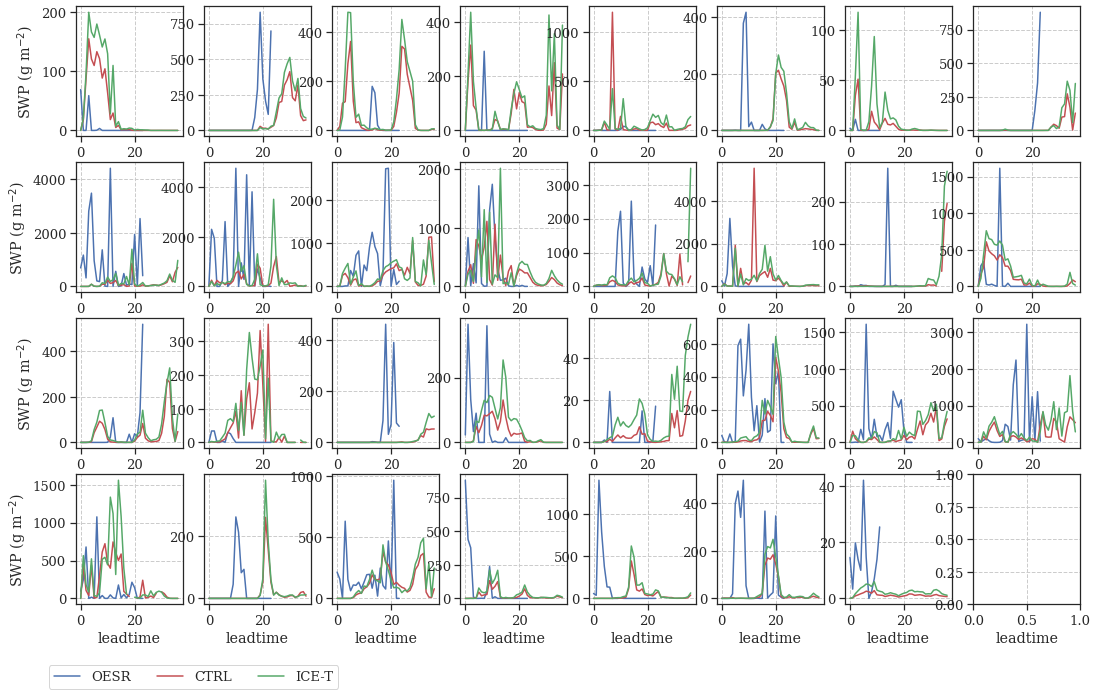

In [45]:
fig, axsm  = plt.subplots(4, 8, #sharex = 'all', 
                         # sharey = 'all',
                         figsize = [18,11])
axs = axsm.flatten()
for Date, i in zip(date, np.arange(date.shape[0])):
    axs[i].plot(SWP[meps][Date],label='OESR', color = 'b')

    axs[i].plot(SWP_MEPS['CTRL'][Date], label='CTRL', color = 'r')
    axs[i].plot(SWP_MEPS['ICE-T'][Date], label='ICE-T', color = 'g')

for ax in axsm.flat:
    ax.set(ylabel='SWP (g m$^{-2}$)', xlabel='leadtime')

for i, k, l, m in zip(range(1,8), range(9,16), range(17, 24), range(25,32)):
    axs[i].yaxis.label.set_visible(False)
    axs[k].yaxis.label.set_visible(False)
    axs[l].yaxis.label.set_visible(False)
    axs[m].yaxis.label.set_visible(False)
    
for i in range(0,24):
    axs[i].xaxis.label.set_visible(False)
#Get the lengend handles and labels
h1, l1 = axs[0].get_legend_handles_labels()
#Make the legend
axs[0].legend(h1, l1,  
              #bbox_to_anchor=(0,-.05, 2.2,-0.15), 
              bbox_to_anchor=(0.6, -4.12, 1., .102),
              loc=9,
           ncol=4)


plt.subplots_adjust(wspace = 0.2, hspace=0.2);
plt.tight_layout()

if savefig == 1:
    fig_name = 'winter_16_17_SWP_daily_mean.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
#plt.close()

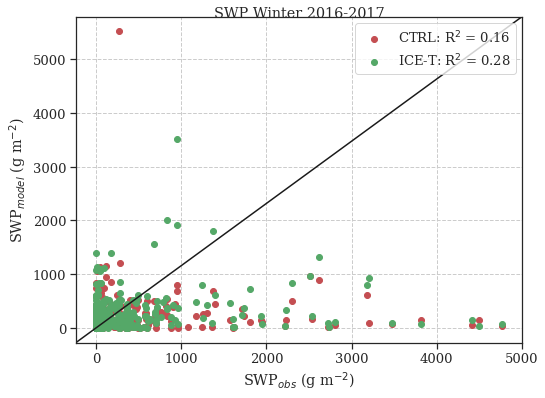

In [46]:
fig, axsm  = plt.subplots(1, 1, #sharex = 'all', 
                         # sharey = 'all',
                         figsize = [8,6])

cc_c = np.round( np.ma.corrcoef(np.ma.masked_invalid(_SWP), np.ma.masked_invalid(_SWP_c))[0,1], 2)
cc_x = np.round( np.ma.corrcoef(np.ma.masked_invalid(_SWP), np.ma.masked_invalid(_SWP_x))[0,1], 2)

axsm.scatter(_SWP, _SWP_c,color = 'r', label = 'CTRL: R$^2$ = %s' %cc_c)
axsm.scatter(_SWP, _SWP_x,color = 'g', label = 'ICE-T: R$^2$ = %s' %cc_x)        
axsm.plot([0, 1], [0, 1], transform=axsm.transAxes, color = 'k')

axsm.set(xlabel='SWP$_{obs}$ (g m$^{-2}$)', ylabel='SWP$_{model}$ (g m$^{-2}$)')

axsm.legend(loc = 'upper right')
axsm.text(0.5, 1.01,
                'SWP Winter 2016-2017',
                horizontalalignment='center',
                verticalalignment='center',
                transform = axsm.transAxes)
if savefig == 1:
    fig_name = 'winter_16_17_SWP_correlation.'+form
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' % (figdir, fig_name))
#plt.close()